### Test for SCZ data

In [1]:
data <- read.table("../data/scz_data_Feb_2016_including_noexac.txt", header = TRUE)
dim(data)
ntrio <- 617 #Menachem  Yes
ntrio <- ntrio + 14 #Girard Yes
ntrio <- ntrio + 105 #Gulsuner Yes
ntrio <- ntrio + 57 #McCarthy Yes
ntrio <- ntrio + 231 #Xu Yes

ntrio
ncase = 4954
ncontrol <- 6239
N <- list(dn=ntrio, ca=ncase, cn= ncontrol)
library("rstan")


[1] 21376    51

[1] 1024

Loading required package: ggplot2
rstan (Version 2.9.0, packaged: 2016-01-05 16:17:47 UTC, GitRev: 05c3d0058b6a)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


In [2]:
parallel::detectCores()

[1] 4

In [3]:
data <- data[data$mut_lof > 0, ]
dim(data)
data <- data[data$mut_missense> 0,]
dim(data)
(colnames(data))

[1] 21346    51

[1] 18986    51

[1] "Gene"                                      
 [2] "mut_lof"                                   
 [3] "mut_missense"                              
 [4] "dn_damaging"                               
 [5] "dn_lof"                                    
 [6] "control_damaging"                          
 [7] "case_damaging"                             
 [8] "control_lof"                               
 [9] "case_lof"                                  
[10] "mut_damaging"                              
[11] "dn_missense"                               
[12] "case_missense_maf001"                      
[13] "control_missense_maf001"                   
[14] "case_missense_maf001_noexac"               
[15] "control_missense_maf001_noexac"            
[16] "case_lof_maf001"                           
[17] "control_lof_maf001"                        
[18] "case_lof_maf001_noexac"                    
[19] "control_lof_maf001_noexac"                 
[20] "case_missense_maf005"                      
[21] "control_missense_maf005"                   
[22] "case_missense_maf005_noexac"               
[23] "control_missense_maf005_noexac"            
[24] "case_lof_maf005"                           
[25] "control_lof_maf005"                        
[26] "case_lof_maf005_noexac"                    
[27] "control_lof_maf005_noexac"                 
[28] "case_missense_Singleton"                   
[29] "control_missense_Singleton"                
[30] "case_missense_Singleton_noexac"            
[31] "control_missense_Singleton_noexac"         
[32] "case_lof_Singleton"                        
[33] "control_lof_Singleton"                     
[34] "case_lof_Singleton_noexac"                 
[35] "control_lof_Singleton_noexac"              
[36] "case_discruptive_Singleton_broad"          
[37] "control_discruptive_Singleton_broad"       
[38] "case_damaging_Singleton_broad"             
[39] "control_damaging_Singleton_broad"          
[40] "case_deleterious_Singleton_broad"          
[41] "control_deleterious_Singleton_broad"       
[42] "case_missense_Singleton_broad"             
[43] "control_missense_Singleton_broad"          
[44] "case_discruptive_Singleton_broad_noexac"   
[45] "control_discruptive_Singleton_broad_noexac"
[46] "case_damaging_Singleton_broad_noexac"      
[47] "control_damaging_Singleton_broad_noexac"   
[48] "case_missense_Singleton_broad_noexac"      
[49] "control_missense_Singleton_broad_noexac"   
[50] "case_deleterious_Singleton_broad_noexac"   
[51] "control_deleterious_Singleton_broad_noexac"

In [4]:
denovoCCBinom2 <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];

int<lower=0> yCaseMis3[NN];
int<lower=0> yTotalMis3[NN];
int<lower=0> yMis3dn[NN];
real<lower=0> mutMis3[NN];

real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.4> pi0;

real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;

real<lower=1> hyperGammaMeanMis3cc;
real<lower=0.5> hyperBetaMis3cc;
real<lower=0.5> gammaMis3cc;
real<lower=1> hyperGammaMeanMis3dn;
real<lower=0.5> hyperBetaMis3dn;
real<lower=0.5> gammaMis3dn;

}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
//pi0 ~ uniform(0, 0.2); //normal(0.04, 0.05);
hyperGammaMeanLoFdn ~ normal(15, 10);
hyperBetaLoFdn ~ normal(1, 0.01);

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);

////
hyperGammaMeanMis3dn ~ normal(15, 10);
hyperBetaMis3dn ~ normal(1, 0.01);
//gammaMis3dn ~ gamma(hyperGammaMeanMis3dn*hyperBetaMis3dn, hyperBetaMis3dn);

hyperGammaMeanMis3cc ~ normal(15, 10);
hyperBetaMis3cc ~ normal(4, 0.01);
gammaMis3cc ~ gamma(hyperGammaMeanMis3cc*hyperBetaMis3cc, hyperBetaMis3cc);

gammaMis3dn ~ gamma(hyperGammaMeanMis3dn*hyperBetaMis3dn, hyperBetaMis3dn);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);


for (ii in 1:NN){

ps[1] <- log1m(pi0) 
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]) + poisson_log(yMis3dn[ii], Ndn*2*mutMis3[ii])
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0) + binomial_log(yCaseMis3[ii], yTotalMis3[ii], thetaH0);
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]) + binomial_log(yMis3dn[ii], Ndn, 2*mutMis3[ii])
//+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], thetaH0);

ps[2] <- log(pi0)
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]*gammaLoFdn) + poisson_log(yMis3dn[ii], Ndn*2*mutMis3[ii]*gammaMis3dn) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol))
+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], gammaMis3cc*Ncase/(gammaMis3cc*Ncase + Ncontrol));

//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn) + binomial_log(yMis3dn[ii], Ndn, 2*mutMis3[ii]*gammaMis3dn) 
//+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], gammaMis3cc*Ncase/(gammaMis3cc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"




In [5]:

y.case.lof <- data$case_lof_Singleton_noexac
y.control.lof <- data$control_lof_Singleton_noexac
y.case.mis3 <- data$case_missense_Singleton_noexac
y.control.mis3 <- data$control_missense_Singleton_noexac

yLoF <- data$dn_lof
mutLoF <- data$mut_lof

NN = length(y.case.lof)
yMis3 <- data$dn_missense
mutMis3 <- data$mut_missense


mixdataDenovoCC2 <- list(K = 2, 
                         yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                         
                         yCaseMis3 = y.case.mis3, yTotalMis3 = y.case.mis3 + y.control.mis3,
                         
                         yLoFdn = yLoF, mutLoF = mutLoF,
                         yMis3dn = yMis3, mutMis3 = mutMis3,
                         
                         NN = length(y.case.lof),
                         Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                         Ndn = N$dn,
                         thetaH0 = N$ca/(N$ca + N$cn))


In [6]:

library("rstan")
nIteration <- 3000
nThin <- floor(nIteration/1000)
nChain <- nCore <- 2

testFitDenovoCC2_Singleton_noexac <- stan(model_code = denovoCCBinom2,
                         data = mixdataDenovoCC2, iter = nIteration, 
                         thin = nThin, chains = nChain, cores = nCore, 
#                         control = list(adapt_delta = 0.9),
                         pars = c('pi0',
                                  'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                  'hyperGammaMeanMis3dn',
                                 'hyperGammaMeanMis3cc'))


clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'


Inference for Stan model: a535e47fc5025af3f165939078be168a.
2 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                          mean se_mean   sd      2.5%       25%       50%
pi0                       0.32    0.00 0.05      0.21      0.28      0.33
hyperGammaMeanLoFdn       5.70    0.08 2.29      1.89      4.01      5.47
hyperGammaMeanLoFcc       1.59    0.01 0.43      1.03      1.25      1.50
hyperGammaMeanMis3dn      1.95    0.02 0.74      1.05      1.40      1.77
hyperGammaMeanMis3cc      1.46    0.01 0.35      1.02      1.19      1.39
lp__                 -41323.44    0.10 2.74 -41329.81 -41325.08 -41323.10
                           75%     97.5% n_eff Rhat
pi0                       0.36      0.40   627    1
hyperGammaMeanLoFdn       7.04     10.67   860    1
hyperGammaMeanLoFcc       1.86      2.62   943    1
hyperGammaMeanMis3dn      2.37      3.90  1000    1
hyperGammaMeanMis3cc      1.65      2.33   84

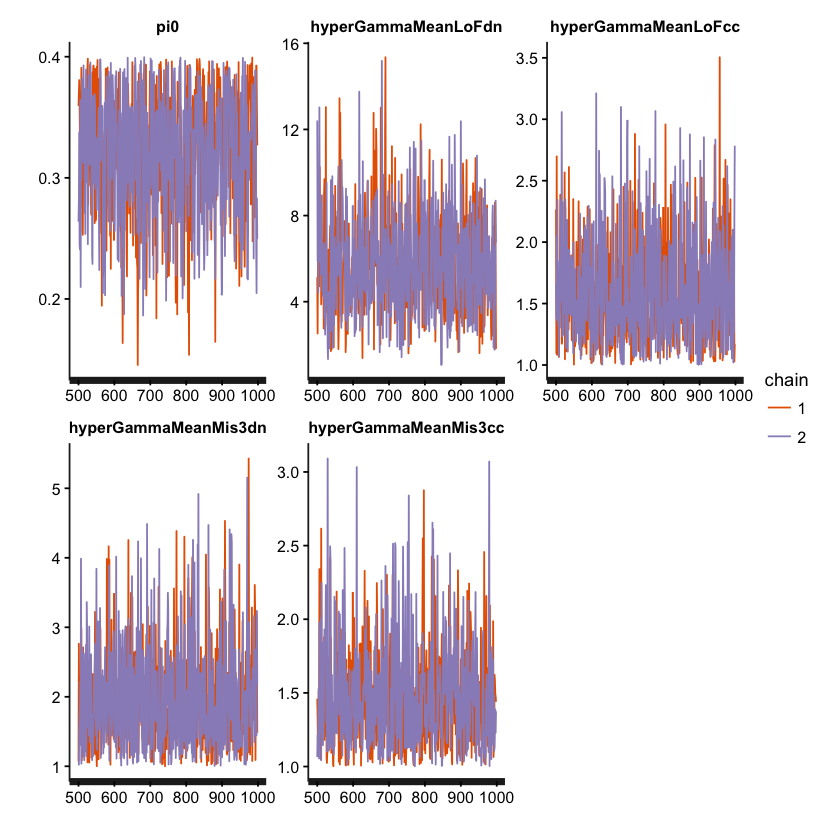

In [7]:
testFitDenovoCC2_Singleton_noexac
stan_trace(testFitDenovoCC2_Singleton_noexac)

## Change prior information 

In [8]:
denovoCCBinom2 <- "
data {
int<lower=1> NN;
int<lower=1> K;
int<lower=1> Ndn;
int<lower=1> Ncase;
int<lower=1> Ncontrol;
int<lower=1> Ntotal;

int<lower=0> yCaseLoF[NN];
int<lower=0> yTotalLoF[NN];
int<lower=0> yLoFdn[NN];
real<lower=0> mutLoF[NN];

int<lower=0> yCaseMis3[NN];
int<lower=0> yTotalMis3[NN];
int<lower=0> yMis3dn[NN];
real<lower=0> mutMis3[NN];

real<lower=0.05> thetaH0;

}
parameters {
real<lower=0.001,upper=0.95> pi0;

real<lower=1> hyperGammaMeanLoFcc;
real<lower=0.5> hyperBetaLoFcc;
real<lower=0.5> gammaLoFcc;
real<lower=1> hyperGammaMeanLoFdn;
real<lower=0.5> hyperBetaLoFdn;
real<lower=0.5> gammaLoFdn;

real<lower=1> hyperGammaMeanMis3cc;
real<lower=0.5> hyperBetaMis3cc;
real<lower=0.5> gammaMis3cc;
real<lower=1> hyperGammaMeanMis3dn;
real<lower=0.5> hyperBetaMis3dn;
real<lower=0.5> gammaMis3dn;

}

model {

real ps[K];
//pi0 ~ normal(0.1, 0.03);
//denovo lof
//pi0 ~ uniform(0, 0.2); //normal(0.04, 0.05);
hyperGammaMeanLoFdn ~ normal(15, 10);
hyperBetaLoFdn ~ normal(1, 0.01);

hyperGammaMeanLoFcc ~ normal(15, 10);
hyperBetaLoFcc ~ normal(4, 0.01);

////
hyperGammaMeanMis3dn ~ normal(15, 10);
hyperBetaMis3dn ~ normal(1, 0.01);
//gammaMis3dn ~ gamma(hyperGammaMeanMis3dn*hyperBetaMis3dn, hyperBetaMis3dn);

hyperGammaMeanMis3cc ~ normal(15, 10);
hyperBetaMis3cc ~ normal(4, 0.01);
gammaMis3cc ~ gamma(hyperGammaMeanMis3cc*hyperBetaMis3cc, hyperBetaMis3cc);

gammaMis3dn ~ gamma(hyperGammaMeanMis3dn*hyperBetaMis3dn, hyperBetaMis3dn);
gammaLoFcc ~ gamma(hyperGammaMeanLoFcc*hyperBetaLoFcc, hyperBetaLoFcc);
gammaLoFdn ~ gamma(hyperGammaMeanLoFdn*hyperBetaLoFdn, hyperBetaLoFdn);


for (ii in 1:NN){

ps[1] <- log1m(pi0) 
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]) + poisson_log(yMis3dn[ii], Ndn*2*mutMis3[ii])
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], thetaH0) + binomial_log(yCaseMis3[ii], yTotalMis3[ii], thetaH0);
//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]) + binomial_log(yMis3dn[ii], Ndn, 2*mutMis3[ii])
//+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], thetaH0);

ps[2] <- log(pi0)
+ poisson_log(yLoFdn[ii], Ndn*2*mutLoF[ii]*gammaLoFdn) + poisson_log(yMis3dn[ii], Ndn*2*mutMis3[ii]*gammaMis3dn) 
+ binomial_log(yCaseLoF[ii], yTotalLoF[ii], gammaLoFcc*Ncase/(gammaLoFcc*Ncase + Ncontrol))
+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], gammaMis3cc*Ncase/(gammaMis3cc*Ncase + Ncontrol));

//+ binomial_log(yLoFdn[ii], Ndn, 2*mutLoF[ii]*gammaLoFdn) + binomial_log(yMis3dn[ii], Ndn, 2*mutMis3[ii]*gammaMis3dn) 
//+ binomial_log(yCaseMis3[ii], yTotalMis3[ii], gammaMis3cc*Ncase/(gammaMis3cc*Ncase + Ncontrol));

increment_log_prob(log_sum_exp(ps));
}

}
"




In [9]:

library("rstan")
nIteration <- 3000
nThin <- floor(nIteration/1000)
nChain <- nCore <- 2

testFitDenovoCC2_Singleton_noexac01 <- stan(model_code = denovoCCBinom2,
                         data = mixdataDenovoCC2, iter = nIteration, 
                         thin = nThin, chains = nChain, cores = nCore, 
#                         control = list(adapt_delta = 0.9),
                         pars = c('pi0',
                                  'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                  'hyperGammaMeanMis3dn',
                                 'hyperGammaMeanMis3cc'))


clang: warning: optimization flag '-ffat-lto-objects' is not supported
clang: warning: argument unused during compilation: '-ffat-lto-objects'


Inference for Stan model: aa61a0478d9178d015f74dd6687c43a9.
2 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                          mean se_mean   sd      2.5%       25%       50%
pi0                       0.44    0.01 0.15      0.22      0.34      0.42
hyperGammaMeanLoFdn       5.07    0.09 2.19      1.45      3.41      4.82
hyperGammaMeanLoFcc       1.59    0.01 0.42      1.02      1.26      1.51
hyperGammaMeanMis3dn      2.04    0.03 0.82      1.03      1.42      1.86
hyperGammaMeanMis3cc      1.47    0.01 0.36      1.02      1.20      1.39
lp__                 -41321.26    0.12 2.94 -41327.88 -41322.98 -41320.95
                           75%     97.5% n_eff Rhat
pi0                       0.51      0.84   270    1
hyperGammaMeanLoFdn       6.51      9.88   629    1
hyperGammaMeanLoFcc       1.86      2.56   913    1
hyperGammaMeanMis3dn      2.47      4.06   829    1
hyperGammaMeanMis3cc      1.66      2.36  100

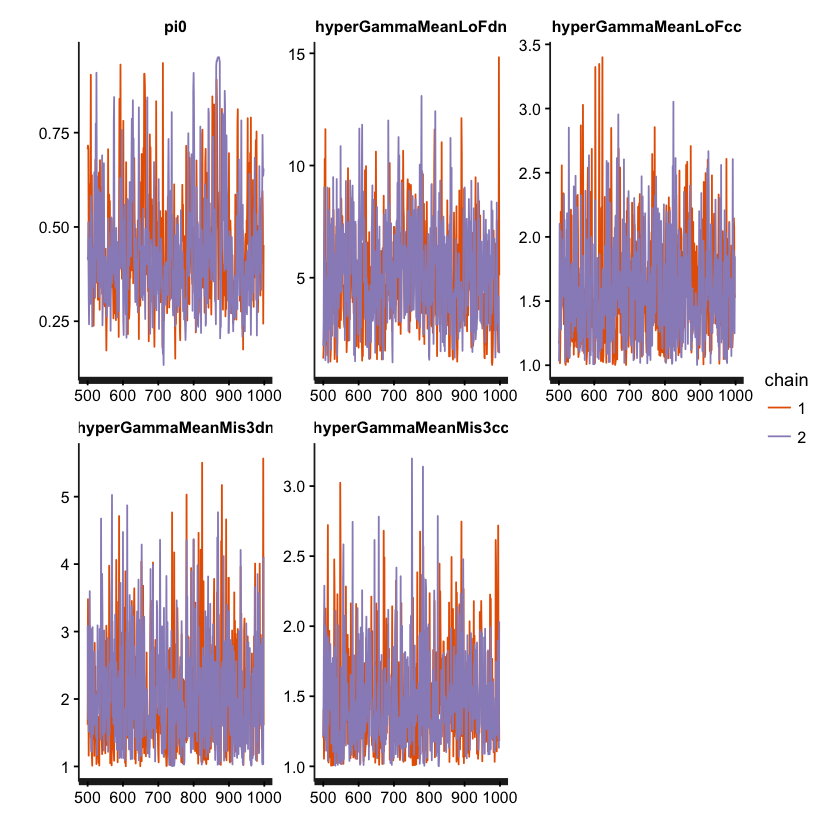

In [10]:
testFitDenovoCC2_Singleton_noexac01
stan_trace(testFitDenovoCC2_Singleton_noexac01)

In [10]:

y.case.lof <- data$case_lof_Singleton
y.control.lof <- data$control_lof_Singleton
y.case.mis3 <- data$case_missense_Singleton
y.control.mis3 <- data$control_missense_Singleton

yLoF <- data$dn_lof
mutLoF <- data$mut_lof

NN = length(y.case.lof)
yMis3 <- data$dn_missense
mutMis3 <- data$mut_missense


mixdataDenovoCC2 <- list(K = 2, 
                         yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                         
                         yCaseMis3 = y.case.mis3, yTotalMis3 = y.case.mis3 + y.control.mis3,
                         
                         yLoFdn = yLoF, mutLoF = mutLoF,
                         yMis3dn = yMis3, mutMis3 = mutMis3,
                         
                         NN = length(y.case.lof),
                         Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                         Ndn = N$dn,
                         thetaH0 = N$ca/(N$ca + N$cn))


In [11]:

library("rstan")
nIteration <- 3000
nThin <- floor(nIteration/1000)
nChain <- nCore <- 2

testFitDenovoCC2_Singleton <- stan(model_code = denovoCCBinom2,
                         data = mixdataDenovoCC2, iter = nIteration, 
                         thin = nThin, chains = nChain, cores = nCore, 
#                         control = list(adapt_delta = 0.9),
                         pars = c('pi0',
                                  'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                  'hyperGammaMeanMis3dn',
                                 'hyperGammaMeanMis3cc'))


Inference for Stan model: a535e47fc5025af3f165939078be168a.
2 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                          mean se_mean   sd      2.5%       25%       50%
pi0                       0.29    0.00 0.07      0.16      0.24      0.30
hyperGammaMeanLoFdn       6.10    0.09 2.60      1.89      4.22      5.86
hyperGammaMeanLoFcc       1.59    0.02 0.43      1.03      1.26      1.53
hyperGammaMeanMis3dn      2.00    0.03 0.83      1.04      1.35      1.80
hyperGammaMeanMis3cc      1.49    0.01 0.37      1.03      1.20      1.41
lp__                 -49108.81    0.10 2.63 -49114.84 -49110.46 -49108.45
                           75%     97.5% n_eff Rhat
pi0                       0.35      0.39   618    1
hyperGammaMeanLoFdn       7.64     11.92   895    1
hyperGammaMeanLoFcc       1.82      2.66   831    1
hyperGammaMeanMis3dn      2.43      3.92   909    1
hyperGammaMeanMis3cc      1.69      2.45   94

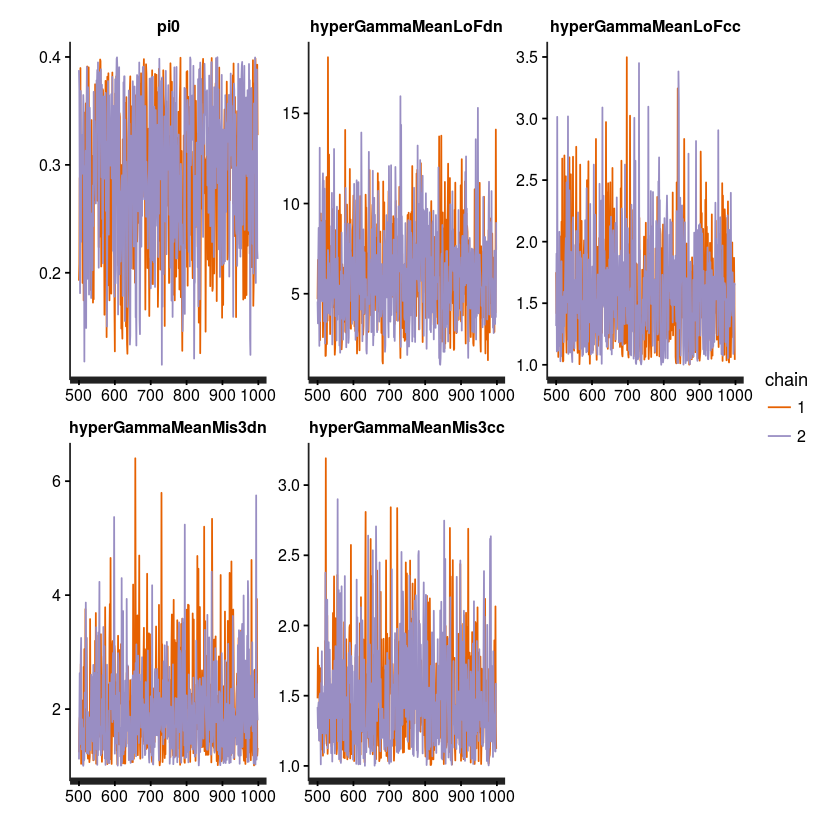

In [12]:
testFitDenovoCC2_Singleton
stan_trace(testFitDenovoCC2_Singleton)

In [13]:

y.case.lof <- data$case_lof_maf001
y.control.lof <- data$control_lof_maf001
y.case.mis3 <- data$case_missense_maf001
y.control.mis3 <- data$control_missense_maf001

yLoF <- data$dn_lof
mutLoF <- data$mut_lof

NN = length(y.case.lof)
yMis3 <- data$dn_missense
mutMis3 <- data$mut_missense


mixdataDenovoCC2 <- list(K = 2, 
                         yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                         
                         yCaseMis3 = y.case.mis3, yTotalMis3 = y.case.mis3 + y.control.mis3,
                         
                         yLoFdn = yLoF, mutLoF = mutLoF,
                         yMis3dn = yMis3, mutMis3 = mutMis3,
                         
                         NN = length(y.case.lof),
                         Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                         Ndn = N$dn,
                         thetaH0 = N$ca/(N$ca + N$cn))


In [14]:

library("rstan")
nIteration <- 3000
nThin <- floor(nIteration/1000)
nChain <- nCore <- 2

testFitDenovoCC2_Singleton_maf001 <- stan(model_code = denovoCCBinom2,
                         data = mixdataDenovoCC2, iter = nIteration, 
                         thin = nThin, chains = nChain, cores = nCore, 
#                         control = list(adapt_delta = 0.9),
                         pars = c('pi0',
                                  'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                  'hyperGammaMeanMis3dn',
                                 'hyperGammaMeanMis3cc'))


Inference for Stan model: a535e47fc5025af3f165939078be168a.
2 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                          mean se_mean   sd      2.5%       25%       50%
pi0                       0.27    0.00 0.05      0.18      0.23      0.27
hyperGammaMeanLoFdn       6.07    0.09 2.37      2.14      4.35      5.81
hyperGammaMeanLoFcc       1.53    0.01 0.39      1.02      1.21      1.45
hyperGammaMeanMis3dn      1.96    0.03 0.80      1.05      1.35      1.74
hyperGammaMeanMis3cc      1.46    0.01 0.38      1.01      1.17      1.38
lp__                 -68443.68    0.11 2.88 -68450.29 -68445.41 -68443.32
                           75%     97.5% n_eff Rhat
pi0                       0.31      0.38   565    1
hyperGammaMeanLoFdn       7.54     11.39   630    1
hyperGammaMeanLoFcc       1.77      2.51  1000    1
hyperGammaMeanMis3dn      2.31      3.96  1000    1
hyperGammaMeanMis3cc      1.67      2.35   82

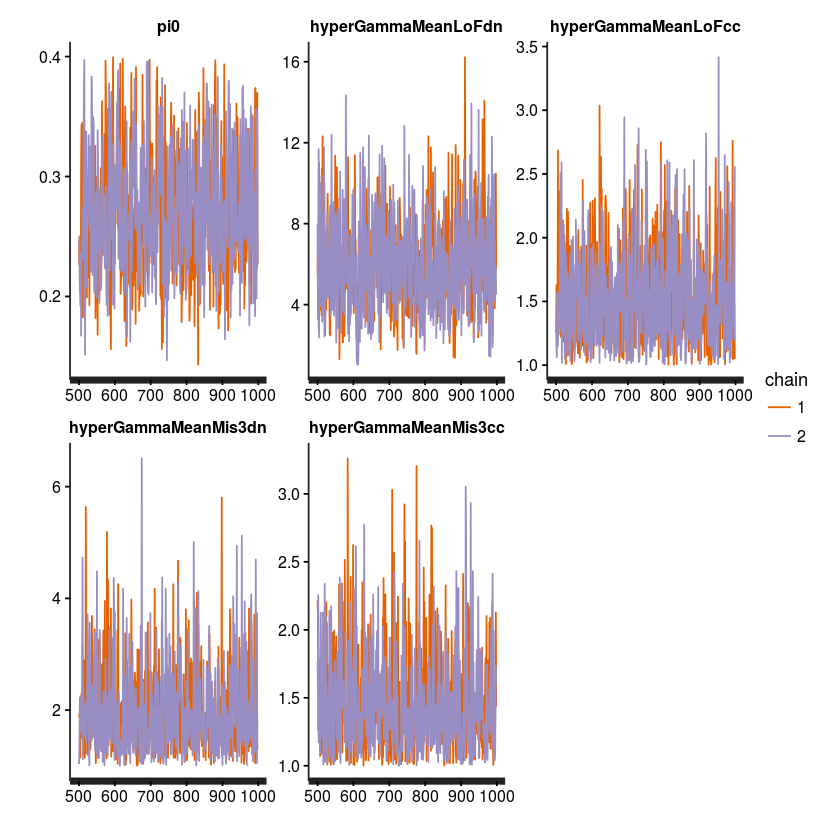

In [26]:
testFitDenovoCC2_Singleton_maf001
stan_trace(testFitDenovoCC2_Singleton_maf001)

In [16]:

y.case.lof <- data$case_lof_maf001_noexac
y.control.lof <- data$control_lof_maf001_noexac
y.case.mis3 <- data$case_missense_maf001_noexac
y.control.mis3 <- data$control_missense_maf001_noexac

yLoF <- data$dn_lof
mutLoF <- data$mut_lof

NN = length(y.case.lof)
yMis3 <- data$dn_missense
mutMis3 <- data$mut_missense


mixdataDenovoCC2 <- list(K = 2, 
                         yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                         
                         yCaseMis3 = y.case.mis3, yTotalMis3 = y.case.mis3 + y.control.mis3,
                         
                         yLoFdn = yLoF, mutLoF = mutLoF,
                         yMis3dn = yMis3, mutMis3 = mutMis3,
                         
                         NN = length(y.case.lof),
                         Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                         Ndn = N$dn,
                         thetaH0 = N$ca/(N$ca + N$cn))


In [17]:

library("rstan")
nIteration <- 3000
nThin <- floor(nIteration/1000)
nChain <- nCore <- 2

testFitDenovoCC2_Singleton_maf001_noexac <- stan(model_code = denovoCCBinom2,
                         data = mixdataDenovoCC2, iter = nIteration, 
                         thin = nThin, chains = nChain, cores = nCore, 
#                         control = list(adapt_delta = 0.9),
                         pars = c('pi0',
                                  'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                  'hyperGammaMeanMis3dn',
                                 'hyperGammaMeanMis3cc'))


Inference for Stan model: a535e47fc5025af3f165939078be168a.
2 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                          mean se_mean   sd      2.5%       25%       50%
pi0                       0.35    0.00 0.03      0.27      0.33      0.35
hyperGammaMeanLoFdn       5.17    0.07 2.04      1.78      3.58      5.07
hyperGammaMeanLoFcc       1.50    0.01 0.40      1.02      1.19      1.41
hyperGammaMeanMis3dn      2.02    0.03 0.76      1.04      1.44      1.84
hyperGammaMeanMis3cc      1.43    0.01 0.33      1.02      1.16      1.35
lp__                 -50855.77    0.12 2.88 -50862.62 -50857.29 -50855.46
                           75%     97.5% n_eff Rhat
pi0                       0.38      0.40   814    1
hyperGammaMeanLoFdn       6.49      9.54   788    1
hyperGammaMeanLoFcc       1.71      2.58  1000    1
hyperGammaMeanMis3dn      2.46      3.81   915    1
hyperGammaMeanMis3cc      1.62      2.18  100

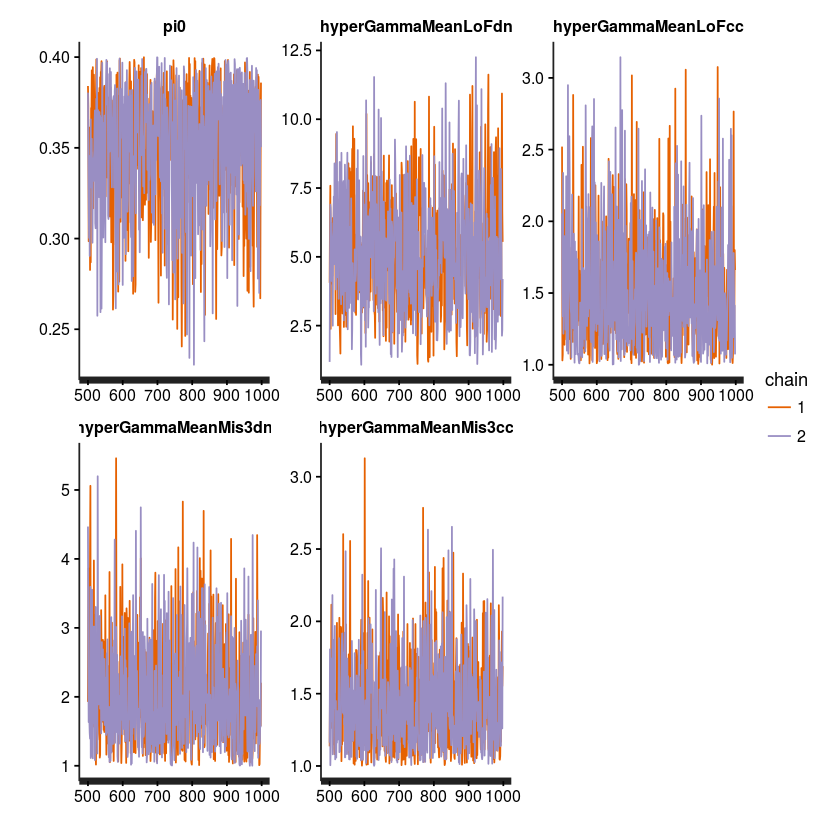

In [27]:
testFitDenovoCC2_Singleton_maf001_noexac
stan_trace(testFitDenovoCC2_Singleton_maf001_noexac)

In [19]:

y.case.lof <- data$case_lof_maf005_noexac
y.control.lof <- data$control_lof_maf005_noexac
y.case.mis3 <- data$case_missense_maf005_noexac
y.control.mis3 <- data$control_missense_maf005_noexac

yLoF <- data$dn_lof
mutLoF <- data$mut_lof

NN = length(y.case.lof)
yMis3 <- data$dn_missense
mutMis3 <- data$mut_missense


mixdataDenovoCC2 <- list(K = 2, 
                         yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                         
                         yCaseMis3 = y.case.mis3, yTotalMis3 = y.case.mis3 + y.control.mis3,
                         
                         yLoFdn = yLoF, mutLoF = mutLoF,
                         yMis3dn = yMis3, mutMis3 = mutMis3,
                         
                         NN = length(y.case.lof),
                         Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                         Ndn = N$dn,
                         thetaH0 = N$ca/(N$ca + N$cn))


In [21]:

library("rstan")
nIteration <- 3000
nThin <- floor(nIteration/1000)
nChain <- nCore <- 2

testFitDenovoCC2_Singleton_maf005_noexac <- stan(model_code = denovoCCBinom2,
                         data = mixdataDenovoCC2, iter = nIteration, 
                         thin = nThin, chains = nChain, cores = nCore, 
#                         control = list(adapt_delta = 0.9),
                         pars = c('pi0',
                                  'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                  'hyperGammaMeanMis3dn',
                                 'hyperGammaMeanMis3cc'))


Inference for Stan model: a535e47fc5025af3f165939078be168a.
2 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                          mean se_mean   sd      2.5%       25%       50%
pi0                       0.35    0.00 0.03      0.27      0.32      0.35
hyperGammaMeanLoFdn       5.32    0.07 2.09      2.04      3.77      5.10
hyperGammaMeanLoFcc       1.52    0.01 0.37      1.03      1.23      1.46
hyperGammaMeanMis3dn      1.98    0.02 0.76      1.04      1.38      1.83
hyperGammaMeanMis3cc      1.45    0.01 0.37      1.01      1.17      1.35
lp__                 -51196.47    0.11 2.75 -51202.59 -51198.18 -51196.03
                           75%     97.5% n_eff Rhat
pi0                       0.38      0.40   783    1
hyperGammaMeanLoFdn       6.57      9.92   952    1
hyperGammaMeanLoFcc       1.70      2.44   826    1
hyperGammaMeanMis3dn      2.40      3.82   940    1
hyperGammaMeanMis3cc      1.66      2.38   91

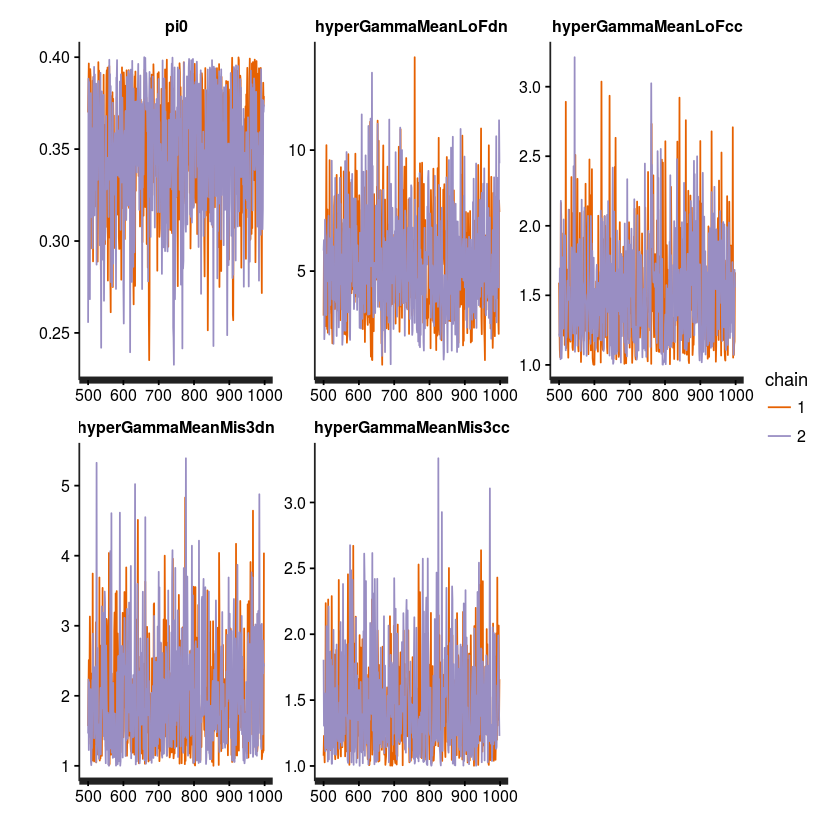

In [28]:
testFitDenovoCC2_Singleton_maf005_noexac
stan_trace(testFitDenovoCC2_Singleton_maf005_noexac)

In [23]:

y.case.lof <- data$case_lof_maf005
y.control.lof <- data$control_lof_maf005
y.case.mis3 <- data$case_missense_maf005
y.control.mis3 <- data$control_missense_maf005

yLoF <- data$dn_lof
mutLoF <- data$mut_lof

NN = length(y.case.lof)
yMis3 <- data$dn_missense
mutMis3 <- data$mut_missense


mixdataDenovoCC2 <- list(K = 2, 
                         yCaseLoF = y.case.lof, yTotalLoF = y.case.lof + y.control.lof,
                         
                         yCaseMis3 = y.case.mis3, yTotalMis3 = y.case.mis3 + y.control.mis3,
                         
                         yLoFdn = yLoF, mutLoF = mutLoF,
                         yMis3dn = yMis3, mutMis3 = mutMis3,
                         
                         NN = length(y.case.lof),
                         Ncase = N$ca, Ncontrol = N$cn, Ntotal = N$ca + N$cn,
                         Ndn = N$dn,
                         thetaH0 = N$ca/(N$ca + N$cn))


In [24]:

library("rstan")
nIteration <- 3000
nThin <- floor(nIteration/1000)
nChain <- nCore <- 2

testFitDenovoCC2_Singleton_maf005 <- stan(model_code = denovoCCBinom2,
                         data = mixdataDenovoCC2, iter = nIteration, 
                         thin = nThin, chains = nChain, cores = nCore, 
#                         control = list(adapt_delta = 0.9),
                         pars = c('pi0',
                                  'hyperGammaMeanLoFdn', 'hyperGammaMeanLoFcc',
                                  'hyperGammaMeanMis3dn',
                                 'hyperGammaMeanMis3cc'))


Inference for Stan model: a535e47fc5025af3f165939078be168a.
2 chains, each with iter=3000; warmup=1500; thin=3; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                          mean se_mean   sd      2.5%       25%       50%
pi0                       0.06    0.00 0.01      0.04      0.06      0.06
hyperGammaMeanLoFdn      10.08    0.12 3.58      3.79      7.61      9.75
hyperGammaMeanLoFcc       1.60    0.01 0.43      1.02      1.28      1.51
hyperGammaMeanMis3dn      2.01    0.03 0.82      1.02      1.38      1.82
hyperGammaMeanMis3cc      1.45    0.01 0.33      1.02      1.19      1.40
lp__                 -88038.95    0.13 2.91 -88045.79 -88040.54 -88038.51
                           75%     97.5% n_eff Rhat
pi0                       0.07      0.10   791 1.00
hyperGammaMeanLoFdn      12.23     17.39   828 1.00
hyperGammaMeanLoFcc       1.87      2.63   914 1.00
hyperGammaMeanMis3dn      2.49      4.08  1000 1.00
hyperGammaMeanMis3cc      1.65      2.18   86

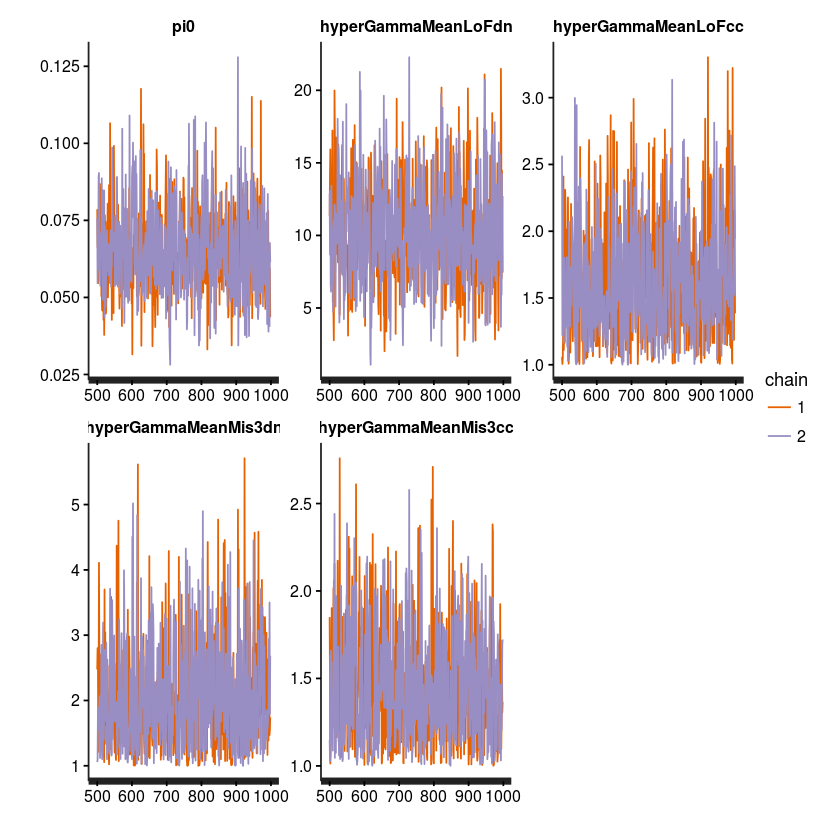

In [29]:
testFitDenovoCC2_Singleton_maf005
stan_trace(testFitDenovoCC2_Singleton_maf005)

In [30]:
save.image("test_private_and_notprivate_damaging_missense_for_case_control_scz_2016.RData")